## Esse notebook exemplifica como a ferramenta de máscara de água de fotos de satélite inclusa na Toolbox GT-607 funciona.

Esse algoritmo foi desenvolvido exclusivamente para fotos do Sentinel-2B e com a barragem de Três Marias em mente. Não há garantias que ele funcione para outros satélites ou outras regiões.
Alguns ajustes nos parâmetros usados no código podem ser necessários para que ele funcione para outras finalidades.

Imports necessários

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import rasterio.features
import rasterio.mask
import configparser
import glob, os
%matplotlib inline

In [15]:
img = rasterio.open("P:\\Teia\\T23KMV_20210620T131241_B07_20m.jp2").read(1)
img = img.astype(float)

In [17]:
img.astype("uint16")

array([[2030, 1735, 1555, ..., 1486, 1537, 1414],
       [1982, 1993, 1973, ..., 1567, 1585, 1509],
       [1795, 1986, 2070, ..., 1519, 1647, 1691],
       ...,
       [2629, 2626, 2525, ..., 2379, 2335, 2241],
       [2622, 2592, 2582, ..., 2192, 1865, 2062],
       [2603, 2600, 2612, ..., 2356, 2055, 2043]], dtype=uint16)

Inicialmente é fornecido uma foto do Sentinel-2B ao algoritmo. Foi empiricamente testado que fotos da sétima banda funcionam melhor.
A imagem é originalmente carregada como uma imagem de 16-bits. No processamento abaixo a foto é convertida para valores de reflectância e normalizada.
Esse pré-processamento na imagem  permite a filtragem de certos aspectos indesejados que se destacam na imagem, como a maior parte da terra-firme, que tem seus valores alterados para 0. 
Para dar continuidade ao processo de criação de máscara para que se possa filtrar os aspectos indesejados restantes da foto é preciso converte-la para uma imagem 8-bits binária.

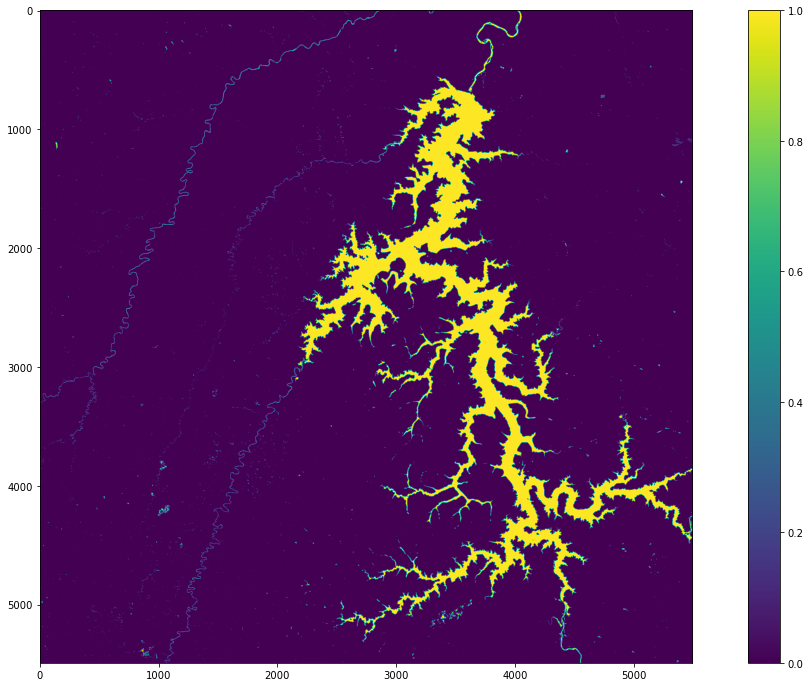

In [2]:
img = rasterio.open("P:\\Teia\\T23KMV_20210620T131241_B07_20m.jp2").read(1)
img = img.astype(float)
img = img / 2 ** 16
img_normalized = (img - img.min()) / (img.max() - img.min())
img_normalized = 1 - img_normalized
img_normalized = img_normalized ** 8
img_normalized = np.round(img_normalized)
img_normalized_uint8 = img_normalized.astype('uint8')
plt.figure(figsize=(20, 12))
plt.imshow(img_normalized)
plt.colorbar()

## Conectando e filtrando polígonos.
Abaixo utiliza-se uma aplicação de teoria dos grafos para determinar a conectividade de grupos de pixels que aparentam fazer parte do mesmo corpo.
Essa metodologia possibilita que a maior parte dos aspectos indesejados restantes da foto sejam removidos.

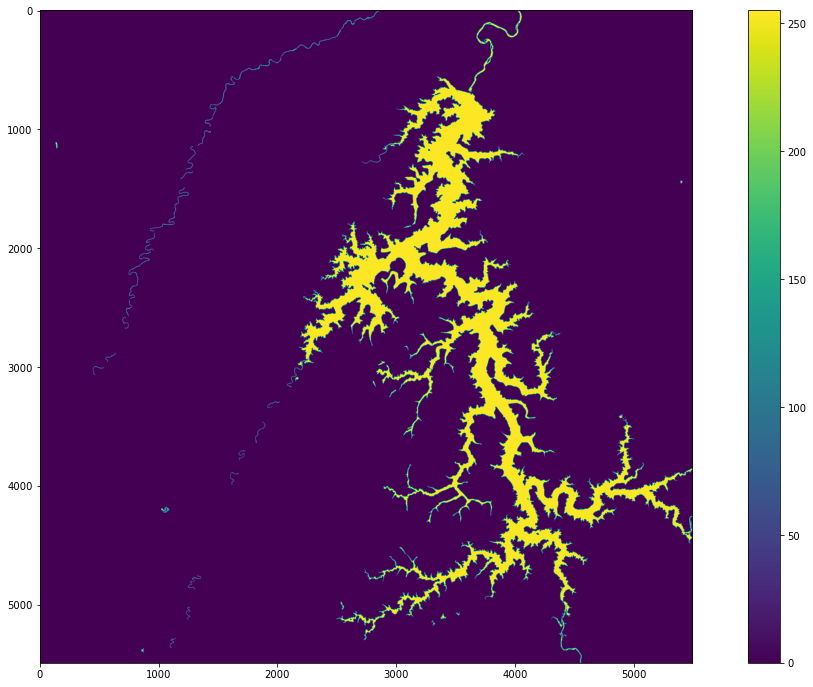

In [3]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_normalized_uint8, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1 #removes background

"""
número minímo de partículas(pixels) a se manter. É um número fixo obtido atráves de experimentação.
"""
min_size = 250


img2 = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255
plt.figure(figsize=(20, 12))
plt.imshow(img2)
plt.colorbar()

## Dilatando a imagem
Como última etapa do processamento a imagem será dilatada. Essa parte do processo é feita para levar em conta épocas de cheia. Para fazer isso, a imagem deve ser convertida para BGR.

In [4]:
matriz = np.zeros([img2.shape[0], img2.shape[1], 3])
matriz[:,:,0] = img2 
matriz[:,:,1] = img2
matriz[:,:,2] = img2
matriz = matriz.astype('uint8')

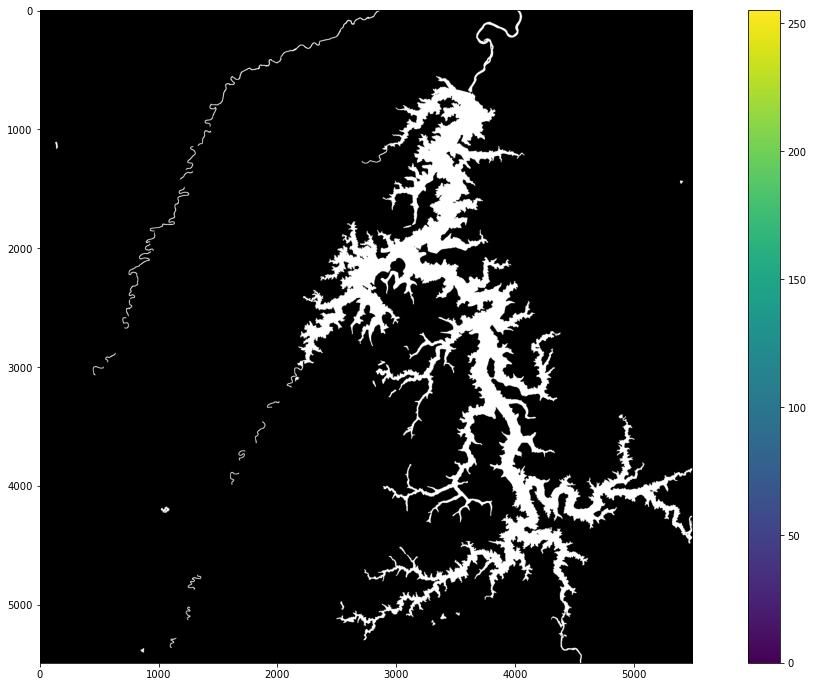

In [5]:
r,g,b = cv2.split(matriz)
img_bgr = cv2.merge([b,g,r])
kernel = np.ones((5,5), np.uint8)  
img_dilate = cv2.dilate(img_bgr, kernel, iterations=1)  
plt.figure(figsize=(20, 12))
plt.imshow(img_dilate)
plt.colorbar()

## Criando a máscara

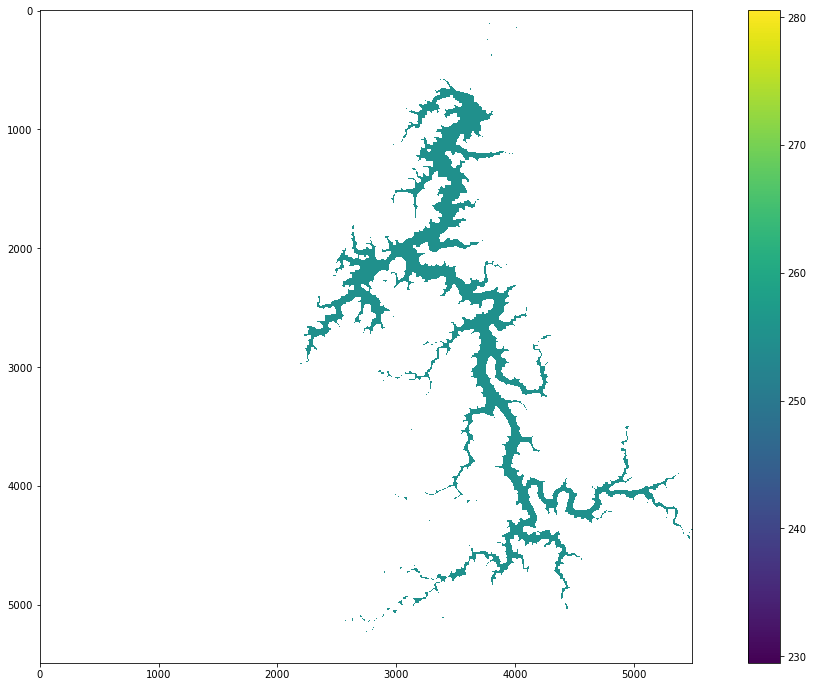

In [6]:
img_dilate_1C = cv2.cvtColor(img_dilate, cv2.COLOR_BGR2GRAY)
np.unique(img_dilate_1C)
img_dilate_1C = img_dilate_1C.astype(float)
mask_1C_dilate = img_dilate_1C.copy()
mask_1C_dilate[img_dilate_1C == 0.0] = 'nan'
plt.figure(figsize=(20, 12))
plt.imshow(mask_1C_dilate, cmap='viridis')
plt.colorbar()

## A máscara em ação

In [7]:
cloud = rasterio.open("P:\\Teia\SENTINELA2A_Outubro\\SENTINEL2A_20211028-131730-888_L2A_T23KMV_C_V1-0_FRE_B7.tif").read(1)

Abaixo é demonstrado o funcionamento da máscara em outra foto, também da sétima banda.

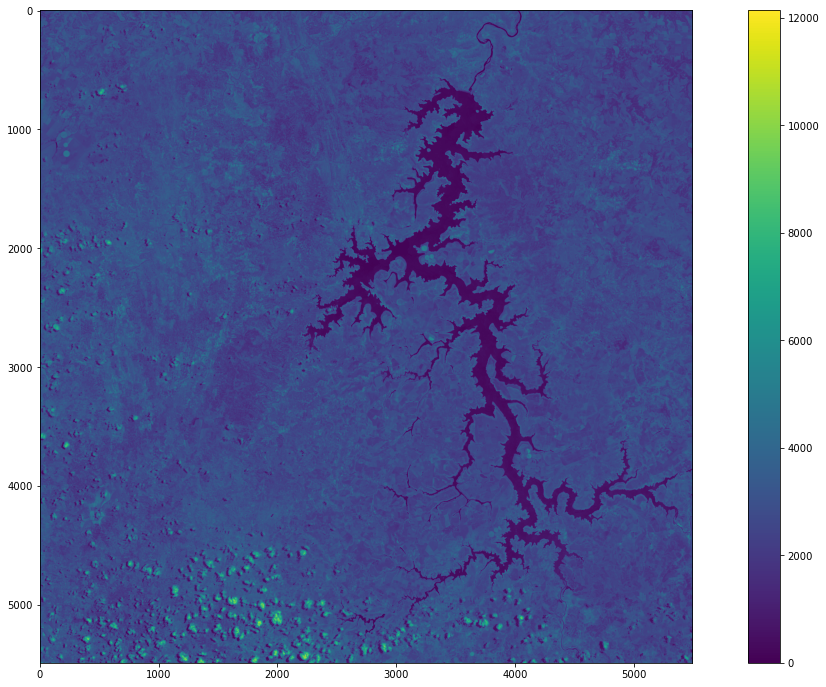

In [8]:
plt.figure(figsize=(20, 12))
plt.imshow(cloud, cmap='viridis')
plt.colorbar()

## Aplicando a máscara
A máscara usa das coordenadas de seus valores nulos para substituir os valores na imagem original na mesma posição, mantendo os valores obtidos para a água.

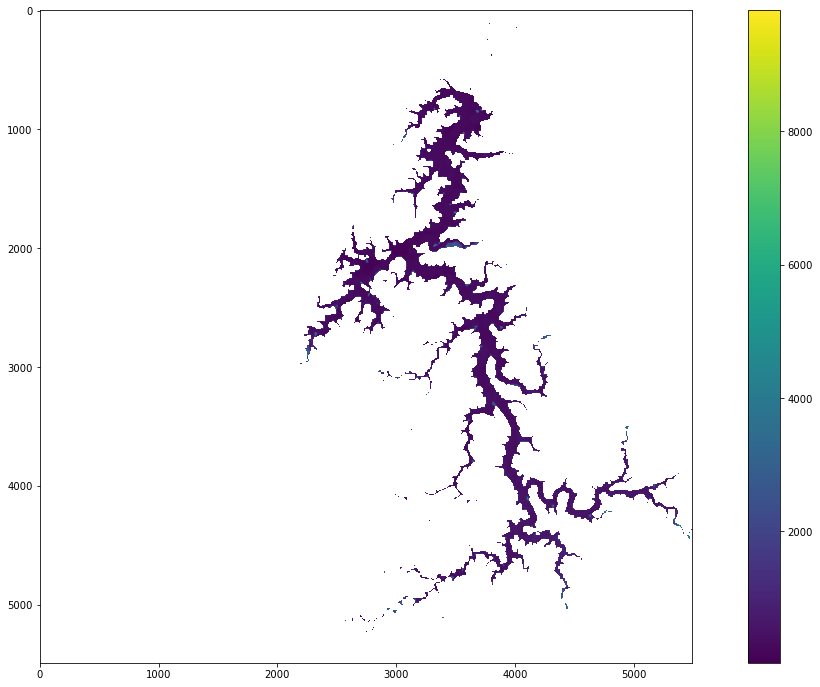

In [9]:
mask_seasonal = np.where(np.isnan(mask_1C_dilate), np.nan, cloud)
plt.figure(figsize=(20, 12))
plt.imshow(mask_seasonal, cmap='viridis')
plt.colorbar()

In [10]:
mask_seasonal.shape

(5490, 5490)

### Aplicação da máscara em sequência em todas as outras bandas do satélite. 

In [17]:
paths = configparser.ConfigParser()
paths.read_file(open(r'config.txt'))
path = paths.get('paths', 'img_list')
img_list = glob.glob(os.path.join(path , '*.tif'))

masked_imgs = []
names = []

def apply_mask():
    for image in img_list:
        namer = image.split('\\')
        split_namer = namer[-1].split('_')
        name = 'masked_' + split_namer[-1]
        final_name = image.replace(split_namer[-1], name)
        final_name = final_name.split('\\')
        final_name = final_name[-1]
        final_name = final_name[:-4]
        band = rasterio.open(image).read(1)
        if band.shape != mask_1C_dilate.shape:
            band  = cv2.imread(image, -1)
            img_half = cv2.resize(band, (0, 0), fx=0.5, fy=0.5)
            mask_band = np.where(np.isnan(mask_1C_dilate), np.nan, img_half)
        else:
            mask_band = np.where(np.isnan(mask_1C_dilate), np.nan, band)
        masked_imgs.append(mask_band)
        names.append(final_name)
apply_mask()

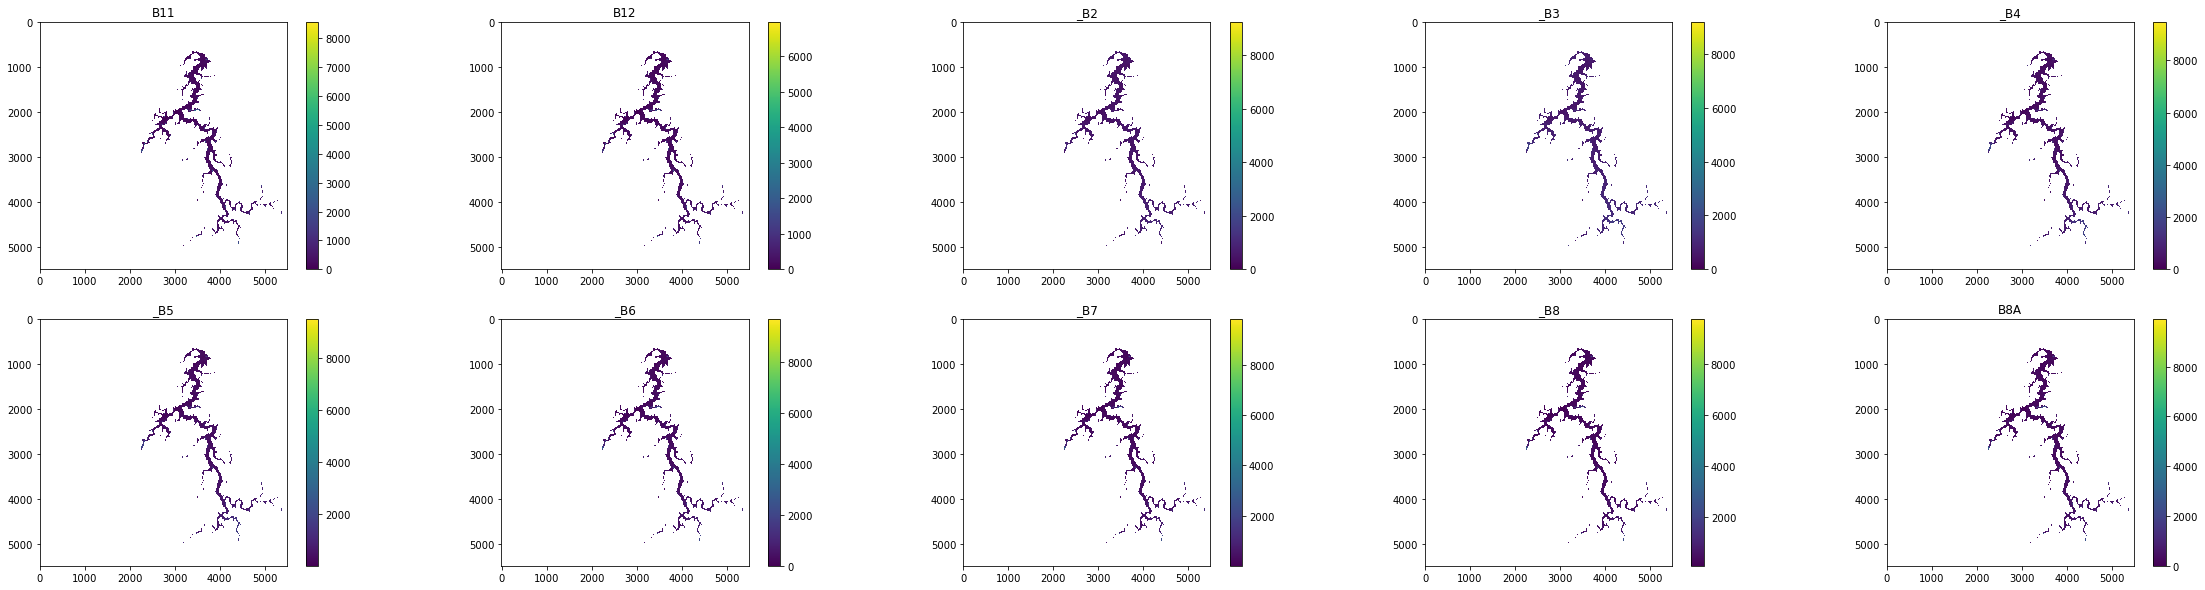

In [18]:
fig = plt.figure(figsize=(40, 10))
columns = 5
rows = 2

ax = []
j = 0
for i in range(columns*rows):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(names[j][-3:])  # set title
    plt.imshow(masked_imgs[j])
    plt.colorbar()
    j +=1

plt.show()